<a href="https://colab.research.google.com/github/surabhipandey18/blank-app/blob/main/foodagri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
path = '/content/drive/MyDrive/Hackathon/Diseases'

In [ ]:
def convert_to_rgba(path):
    try:
        img = Image.open(path)
        if img.mode == 'P' and 'transparency' in img.info:
            img = img.convert('RGBA')
        return img
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = training_generator.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = training_generator.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 11119 images belonging to 33 classes.
Found 2772 images belonging to 33 classes.


In [ ]:
images, labels = next(train_generator)

class_name = train_generator.class_indices

index_to_class_name = {v: k for k, v in class_name.items()}

images_per_class = {}

fig_size = (30, 30)
for i in range(images.shape[0]):
    pred_class_index = labels[i].argmax()
    pred_class = index_to_class_name[pred_class_index]
    if pred_class not in images_per_class:
        images_per_class[pred_class] = images[i]
    if len(images_per_class[pred_class]) == len(class_name):
      break

plt.figure(figsize= (40, 40))
i = 1
for class_name, image in images_per_class.items():
    plt.subplot(1, len(images_per_class), i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.show()


In [ ]:
#CNN model training
recognition_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_compile = recognition_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
recognition_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 33)             │     2,855,457 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,948,705 (11.25 MB)

 Trainable params: 2,948,705 (11.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# plot confusion matrix
y_pred = []
y_true = []

for images, labels in validation_generator:
    predictions = recognition_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels, axis=1)) # Assuming labels are one-hot encoded

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━

KeyboardInterrupt: 

In [ ]:
device = tf.device('/device:GPU:0')
with device:
  history = recognition_model.fit(
    train_generator, epochs = 10, validation_data = validation_generator)

Epoch 1/10
 55/348 ━━━━━━━━━━━━━━━━━━━━ 24:29 5s/step - accuracy: 0.4815 - loss: 1.6690

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5659 - loss: 1.3751

KeyboardInterrupt: 

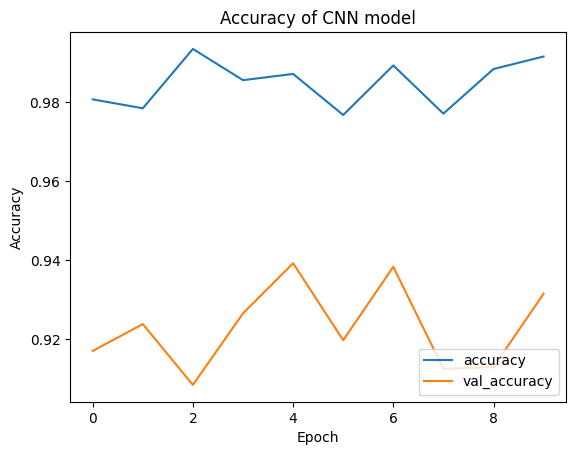

In [ ]:
#accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Accuracy of CNN model")
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step


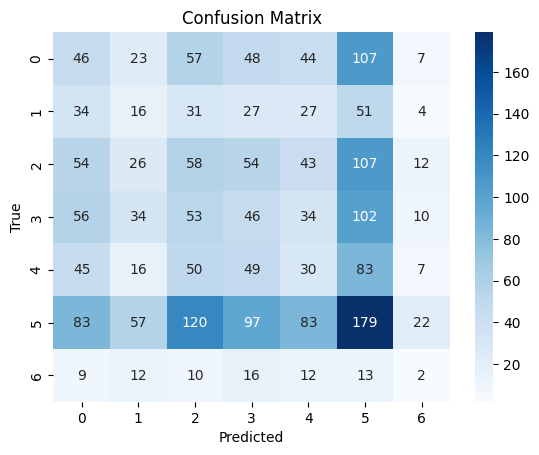

In [ ]:
#plot confusion matrix
y_pred = recognition_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#save recognition model
recognition_model.save('recognition_model.keras')